# GraphSAGE Implementation

```
inproceedings{hamilton2017inductive,
     author = {Hamilton, William L. and Ying, Rex and Leskovec, Jure},
     title = {Inductive Representation Learning on Large Graphs},
     booktitle = {NIPS},
     year = {2017}
   }
```

## Import Library

In [1]:
import torch
import itertools
import torch.nn as nn
import torch.nn.functional as F
from dgl.nn.pytorch import conv as dgl_conv
from utils.startup_data_set import COMP4222Dataset
from utils.PredictorClasses import *
from utils.CustomMetrics import *
import matplotlib.pyplot as plt
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Hyperparameters

In [19]:
val_ratio = 0.1
test_ratio = 0.1

# Hyperparameters
n_hidden = 64
n_layers = 2
out_dim = 16
dropout = 0.5
aggregator_type = 'mean'
lr = 0.01
early_stopping = 10
ep = 100

## Load Dataset

In [3]:
import numpy as np
np.random.seed(0)

In [4]:
dataset = COMP4222Dataset()
graph = dataset[0]
print(graph)

Graph(num_nodes=25446, num_edges=45621,
      ndata_schemes={'feat': Scheme(shape=(221,), dtype=torch.float64), 'label': Scheme(shape=(), dtype=torch.float32)}
      edata_schemes={'feat': Scheme(shape=(23,), dtype=torch.float64)})


In [5]:
in_feats = graph.ndata['feat'].shape[1]
in_feats

221

## Generate Postitve Graph and Negative Graph with Spliting

In [6]:
from utils.CustomUtilities import generate_neg_graph, generate_pos_graph
train_g, train_pos_g, val_pos_g, test_pos_g = \
    generate_pos_graph(graph, val_ratio, test_ratio)

train_g

Graph(num_nodes=25446, num_edges=61943,
      ndata_schemes={'feat': Scheme(shape=(221,), dtype=torch.float64), 'label': Scheme(shape=(), dtype=torch.float32)}
      edata_schemes={'feat': Scheme(shape=(23,), dtype=torch.float64)})

In [7]:
train_neg_g, val_neg_g, test_neg_g = \
    generate_neg_graph(graph, val_ratio, test_ratio)

train_neg_g

Graph(num_nodes=25446, num_edges=36497,
      ndata_schemes={}
      edata_schemes={})

In [8]:
train_g, train_pos_g, val_pos_g, test_pos_g = \
    train_g.to(device), train_pos_g.to(device), val_pos_g.to(device), test_pos_g.to(device)

train_neg_g, val_neg_g, test_neg_g = \
    train_neg_g.to(device), val_neg_g.to(device), test_neg_g.to(device)

## Model Training

### Model Setup

In [9]:
class GraphSAGEModel(nn.Module):
    def __init__(self,
                 in_feats,
                 n_hidden,
                 out_dim,
                 n_layers,
                 activation,
                 dropout,
                 aggregator_type):
        super(GraphSAGEModel, self).__init__()

        self.layers = nn.ModuleList()
        # input layer
        self.layers.append(dgl_conv.SAGEConv(in_feats, n_hidden, aggregator_type,
                                         feat_drop=dropout, activation=activation))
        # hidden layers
        for i in range(n_layers - 1):
            self.layers.append(dgl_conv.SAGEConv(n_hidden, n_hidden, aggregator_type,
                                             feat_drop=dropout, activation=activation))
        # output layer
        self.layers.append(dgl_conv.SAGEConv(n_hidden, out_dim, aggregator_type,
                                         feat_drop=dropout, activation=None))
        
    def forward(self, g, features):
        h = features.float().to(device)
        for layer in self.layers:
            h = layer(g, h).float().to(device)
        return h

In [20]:
gconv_model = GraphSAGEModel(in_feats,
                             n_hidden,
                             out_dim,
                             n_layers,
                             F.relu,
                             dropout,
                             aggregator_type).to(device)

pred = MLPPredictor(int(out_dim)).to(device)

### Training Loop

In [21]:
import itertools

train_loss, val_loss = [], []
train_AUC, val_AUC = [], []
stop = 0

optimizer = torch.optim.Adam(itertools.chain(gconv_model.parameters(), pred.parameters()))
for e in range(ep):
    # forward
    h = gconv_model(train_g, train_g.ndata['feat']).to(device)
    pos_score = pred(train_pos_g, h)
    neg_score = pred(train_neg_g, h)

    loss = compute_loss(pos_score, neg_score)
    train_loss.append(loss.item())
    train_AUC.append(compute_auc(pos_score, neg_score))

    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # validation
    v_pos_score = pred(val_pos_g, h)
    v_neg_score = pred(val_neg_g, h)
    v_loss = compute_loss(v_pos_score, v_neg_score)
    val_loss.append(v_loss.item())
    val_AUC.append(compute_auc(v_pos_score, v_neg_score))

    #verbose
    if e % 10 == 0:
        print('Epoch: {} \t Train loss: {} \t Val loss: {} \t Train AUC: {} \t Val AUC: {}'.format(e, round(loss.item(), 3), round(v_loss.item(), 3), round(train_AUC[-1],3), round(val_AUC[-1], 3)))


    # early stopping
    if e > 10:
        if v_loss.item() > sum(val_loss[-5:])/5:
            stop += 1
        else: 
            stop = 0
        if stop >= early_stopping:
            print("Early Stopped at Epoch {}".format(e))
            break


Epoch: 0 	 Train loss: 0.706 	 Val loss: 0.705 	 Train AUC: 0.565 	 Val AUC: 0.563
Epoch: 10 	 Train loss: 0.676 	 Val loss: 0.677 	 Train AUC: 0.667 	 Val AUC: 0.656
Epoch: 20 	 Train loss: 0.65 	 Val loss: 0.656 	 Train AUC: 0.73 	 Val AUC: 0.704
Epoch: 30 	 Train loss: 0.6 	 Val loss: 0.608 	 Train AUC: 0.811 	 Val AUC: 0.786
Epoch: 40 	 Train loss: 0.52 	 Val loss: 0.542 	 Train AUC: 0.864 	 Val AUC: 0.829
Epoch: 50 	 Train loss: 0.409 	 Val loss: 0.454 	 Train AUC: 0.905 	 Val AUC: 0.869
Epoch: 60 	 Train loss: 0.341 	 Val loss: 0.42 	 Train AUC: 0.923 	 Val AUC: 0.89
Epoch: 70 	 Train loss: 0.304 	 Val loss: 0.407 	 Train AUC: 0.937 	 Val AUC: 0.904
Epoch: 80 	 Train loss: 0.291 	 Val loss: 0.4 	 Train AUC: 0.941 	 Val AUC: 0.909
Epoch: 90 	 Train loss: 0.281 	 Val loss: 0.4 	 Train AUC: 0.944 	 Val AUC: 0.914


In [22]:
# testing AUC
with torch.no_grad():
    pos_score = pred(test_pos_g, h)
    neg_score = pred(test_neg_g, h)
    print('AUC:', compute_auc(pos_score, neg_score))

AUC: 0.9145967555782178


### Result Plotting

Text(0, 0.5, 'Loss')

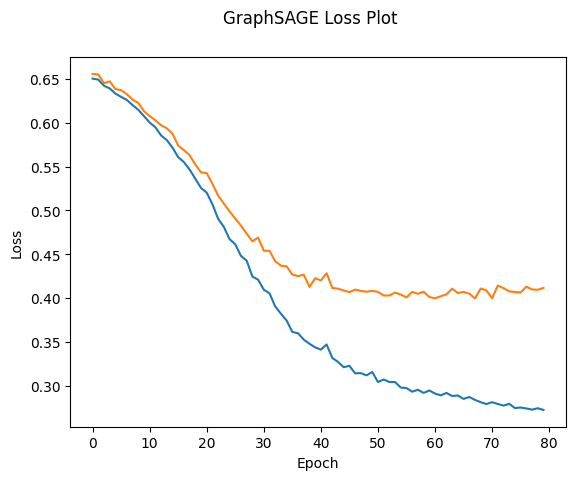

In [23]:
fig = plt.figure()
plt.plot(train_loss[20:], label='training loss')
plt.plot(val_loss[20:], label = 'validation loss')
fig.suptitle('GraphSAGE Loss Plot')
plt.xlabel('Epoch')
plt.ylabel('Loss')

Text(0, 0.5, 'AUC')

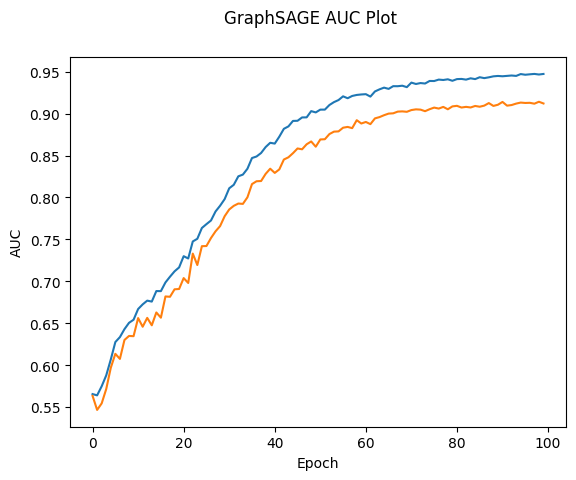

In [24]:
fig = plt.figure()
plt.plot(train_AUC, label='training AUC')
plt.plot(val_AUC, label = 'validation AUC')
fig.suptitle('GraphSAGE AUC Plot')
plt.xlabel('Epoch')
plt.ylabel('AUC')
